In [2]:
%matplotlib inline

import sys
sys.path.append('/mnt/scMVP') 

import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scMVP.dataset import LoadData,GeneExpressionDataset, CellMeasurement
from scMVP.models import VAE_Attention, Multi_VAE_Attention, VAE_Peak_SelfAttention
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch

import scanpy as sc
import anndata

import scipy.io as sp_io
from scipy.sparse import csr_matrix, issparse
print(os.getcwd())

/mnt/scMVP/demos


In [3]:
folder_path = "/mnt/10_GSE201402_down/ATAC"  


for filename in os.listdir(folder_path):
    if filename.endswith(".tsv"):
        tsv_file = os.path.join(folder_path, filename)
        txt_file = os.path.join(folder_path, filename.replace(".tsv", ".txt"))
        data.to_csv(txt_file, sep="\t", index=False)
        print(f"已转换：{filename} 到 {txt_file}")

已转换：barcodes.tsv 到 /mnt/10_GSE201402_down/ATAC/barcodes.txt
已转换：features.tsv 到 /mnt/10_GSE201402_down/ATAC/features.txt


In [3]:
input_path = "/mnt/10_GSE201402_down/"
output_path = "/mnt/appealing/10_GSE201402_down/scMVP_output"

sciCAR_cellline_dataset = {
                "gene_names": 'RNA/features.txt',
                "gene_expression": 'RNA/matrix.mtx',
                "gene_barcodes": 'RNA/barcodes.txt',
                "atac_names": 'ATAC/features.txt',
                "atac_expression": 'ATAC/matrix.mtx',
                "atac_barcodes": 'ATAC/barcodes.txt'
                }

dataset = LoadData(dataset=sciCAR_cellline_dataset,data_path=input_path,
                       dense=False,gzipped=False, atac_threshold=0.001,
                       cell_threshold=1)

[2025-05-24 22:53:03,377] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2025-05-24 22:54:19,655] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2025-05-24 22:54:24,497] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2025-05-24 22:54:24,499] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2025-05-24 22:54:37,076] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2025-05-24 22:54:37,707] INFO - scMVP.dataset.dataset | Downsampled from 9383 to 9383 cells


In [4]:
n_epochs = 10
lr = 1e-3
use_batches = False
use_cuda = True # False if using CPU
n_centroids = 5 
n_alfa = 1.0

multi_vae = Multi_VAE_Attention(dataset.nb_genes, len(dataset.atac_names), n_batch=0, n_latent=20, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

trainer.train(n_epochs=n_epochs, lr=lr)
# create posterior from trained model
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()

np.save(output_path+'/scMVP.npy',latent)

training:   0%|          | 0/10 [00:00<?, ?it/s]logpzc:-68.56109619140625, logqcx:-1.6094379425048828
kld_qz_pz = 28.626926,kld_qz_rna = 6.025018,kld_qz_atac = 5.122890,kl_divergence = 29.141460,reconst_loss_rna = 9180.685547,        reconst_loss_atac = 568.157043, mu=0.000000, sigma=1.000000
reconst_loss = 9785.329102,kl_divergence_local = 29.141460,kl_weight = 1.000000,loss = 9814.470703
tensor(9814.4707, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-50.876953125, logqcx:-1.6094379425048828
kld_qz_pz = 13.638247,kld_qz_rna = 5.804259,kld_qz_atac = 5.068540,kl_divergence = 14.146277,reconst_loss_rna = 6054.061523,        reconst_loss_atac = 508.123718, mu=-0.000012, sigma=1.000966
reconst_loss = 6598.672363,kl_divergence_local = 14.146277,kl_weight = 1.000000,loss = 6612.818848
tensor(6612.8188, device='cuda:0', grad_fn=<DivBackward0>)
logpzc:-46.000858306884766, logqcx:-1.6094379425048828
kld_qz_pz = 10.665089,kld_qz_rna = 7.237521,kld_qz_atac = 6.832728,kl_divergence = 11.342196,

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


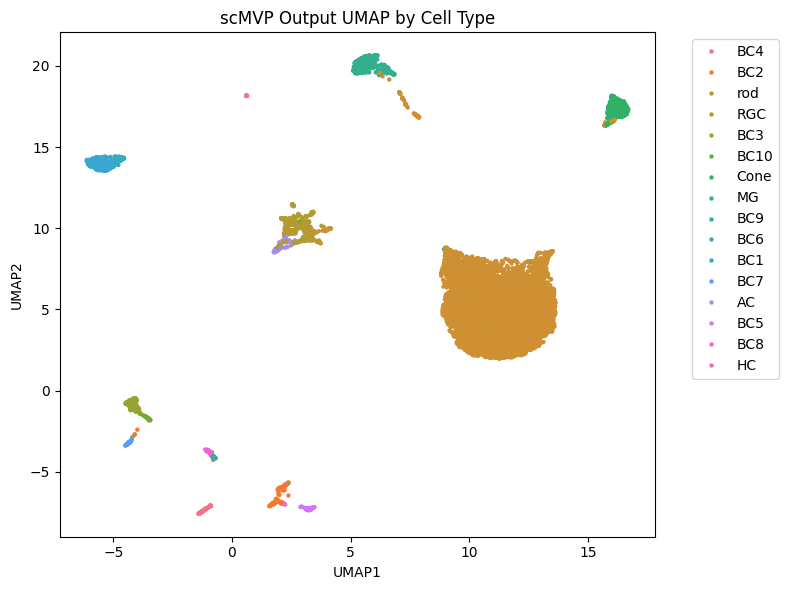

In [5]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
metadata = pd.read_csv("/mnt/10_GSE201402_down/metadata.csv")
assert latent.shape[0] == metadata.shape[0], "Mismatch between embedding and metadata!"
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(latent)
plot_df = pd.DataFrame(embedding_2d, columns=["UMAP1", "UMAP2"])
plot_df["celltype"] = metadata["celltype"].values
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="UMAP1", y="UMAP2", hue="celltype", s=10, linewidth=0)
plt.title("scMVP Output UMAP by Cell Type")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()